<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Image%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!7z x /content/Dataset.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 17231696 bytes (17 MiB)

Extracting archive: /content/Dataset.7z
--
Path = /content/Dataset.7z
Type = 7z
Physical Size = 17231696
Headers Size = 6422
Method = LZMA2:24
Solid = +
Blocks = 1

  0%     18% 23 - Dataset/all_meta_data.csv                                    35% 144 - Dataset/Dibothriocephalus/Diphyllobothrium_tissue_WA_500x2.jpg                                                                          53% 252 - Dataset/Giardia/Giardia_cyst_tric6.j

# Installing and Importing Packages

In [1]:
!pip install einops -q
!pip install tez -q
import numpy as np
import torchvision
import pandas as pd
import PIL
from PIL import Image
import time
import torch
from torchvision import transforms
import torch.nn.functional as F
from einops import rearrange
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import tez
from tez.callbacks import Callback, CallbackRunner
from sklearn import metrics

# Vision Bert

In [2]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class LayerNormalize(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class MLP_Block(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.1):
        super().__init__()
        self.nn1 = nn.Linear(dim, hidden_dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.normal_(self.nn1.bias, std = 1e-6)
        self.af1 = nn.GELU()
        self.do1 = nn.Dropout(dropout)
        self.nn2 = nn.Linear(hidden_dim, dim)
        torch.nn.init.xavier_uniform_(self.nn2.weight)
        torch.nn.init.normal_(self.nn2.bias, std = 1e-6)
        self.do2 = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.nn1(x)
        x = self.af1(x)
        x = self.do1(x)
        x = self.nn2(x)
        x = self.do2(x)
        
        return x

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.1):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5  # 1/sqrt(dim)

        self.to_qkv = nn.Linear(dim, dim * 3, bias = True) # Wq,Wk,Wv for each vector, thats why *3
        torch.nn.init.xavier_uniform_(self.to_qkv.weight)
        torch.nn.init.zeros_(self.to_qkv.bias)
        
        self.nn1 = nn.Linear(dim, dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.zeros_(self.nn1.bias)        
        self.do1 = nn.Dropout(dropout)
        

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x) #gets q = Q = Wq matmul x1, k = Wk mm x2, v = Wv mm x3
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv = 3, h = h) # split into multi head attentions

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1) #follow the softmax,q,d,v equation in the paper

        out = torch.einsum('bhij,bhjd->bhid', attn, v) #product of v times whatever inside softmax
        out = rearrange(out, 'b h n d -> b n (h d)') #concat heads into one matrix, ready for next encoder block
        out =  self.nn1(out)
        out = self.do1(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(LayerNormalize(dim, Attention(dim, heads = heads, dropout = dropout))),
                Residual(LayerNormalize(dim, MLP_Block(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x, mask = None):
        for attention, mlp in self.layers:
            x = attention(x, mask = mask) # go to attention
            x = mlp(x) #go to MLP_Block
        return x


class ViT(tez.Model):
  def __init__(self,*, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dropout = 0.1, emb_dropout = 0.1):
    super().__init__()
    assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
    num_patches = (image_size // patch_size) ** 2  # e.g. (32/4)**2= 64
    patch_dim = channels * patch_size ** 2  # e.g. 3*8**2 = 64*3

    self.patch_size = patch_size
    self.pos_embedding = nn.Parameter(torch.empty(1, (num_patches + 1), dim))
    torch.nn.init.normal_(self.pos_embedding, std = .02) # initialized based on the paper
    self.patch_conv= nn.Conv2d(3,dim, patch_size, stride = patch_size) #eqivalent to x matmul E, E= embedd matrix, this is the linear patch projection
    
    self.cls_token = nn.Parameter(torch.zeros(1, 1, dim)) #initialized based on the paper
    self.dropout = nn.Dropout(emb_dropout)

    self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)

    self.to_cls_token = nn.Identity()

    self.nn1 = nn.Linear(dim, num_classes)  # if finetuning, just use a linear layer without further hidden layers (paper)
    torch.nn.init.xavier_uniform_(self.nn1.weight)
    torch.nn.init.normal_(self.nn1.bias, std = 1e-6)
    
  def monitor_metrics(self, outputs, targets):
    outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    accuracy = metrics.accuracy_score(targets, outputs)
    precision = metrics.precision_score(targets, outputs,average='weighted')
    recall = metrics.recall_score(targets, outputs,average='weighted')
    f1 = metrics.f1_score(targets, outputs,average='weighted')
    return {"accuracy": accuracy,
            "precision":precision,
            "recall":recall,
            "f1":f1}
  def fetch_optimizer(self):
    opt = torch.optim.Adam(self.parameters(), lr=1e-3)
    return opt

  def forward(self, img,targets, mask = None):
    p = self.patch_size

    x = self.patch_conv(img) # each of 64 vecotrs is linearly transformed with a FFN equiv to E matmul
    #x = torch.matmul(x, self.E)
    x = rearrange(x, 'b c h w -> b (h w) c') # 64 vectors in rows representing 64 patches, each 64*3 long

    cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    x += self.pos_embedding
    x = self.dropout(x)

    x = self.transformer(x, mask) #main game

    x = self.to_cls_token(x[:, 0])
    
    outputs = self.nn1(x)
    
    if targets is not None:
      loss = nn.CrossEntropyLoss()(outputs, targets)
      metrics = self.monitor_metrics(outputs, targets)
      return outputs, loss, metrics
    return outputs, 0, {}


## Training VBERT

In [3]:
class CIFAR(torchvision.datasets.CIFAR10):
  def __init__(self, path, transform, train=True,download=True):
      super().__init__(path, train, download=True)
      self.transforms = transform
  def __getitem__(self, index):
      im, label = super().__getitem__(index)
      return {'img':self.transforms(im),'targets':label}

In [28]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 100

DL_PATH = "/content/CIFAR10_data" # Use your own path
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
transform = torchvision.transforms.Compose(
     [torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
     torchvision.transforms.RandomAffine(8, translate=(.15,.15)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_dataset = CIFAR(DL_PATH, train=True,
                                        download=True, transform=transform)

test_dataset = CIFAR(DL_PATH, train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
model = ViT(image_size=32, patch_size=4, num_classes=10, channels=3,
            dim=64, depth=6, heads=8, mlp_dim=128)
es = tez.callbacks.EarlyStopping(monitor="valid_loss", model_path="ViT-CIFAR10.bin")
model.fit(
        train_dataset,
        valid_dataset=test_dataset,
        train_bs=100,
        device="cuda",
        epochs=150,
        callbacks=[es],
        fp16=True,
    )
torch.save(model.state_dict(), '/content/ViT-CIFAR10-final.bin')

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (inf --> 1.7325006895065307). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (1.7325006895065307 --> 1.519312686252594). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (1.519312686252594 --> 1.4115574386596679). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (1.4115574386596679 --> 1.3535720553398132). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (1.3535720553398132 --> 1.2606240270614624). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (1.2606240270614624 --> 1.2362172849178314). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (1.2362172849178314 --> 1.1709228728294372). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (1.1709228728294372 --> 1.1051185081481933). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (1.1051185081481933 --> 1.074740308904648). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (1.074740308904648 --> 1.0428570340633392). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (1.0428570340633392 --> 0.9803798525333405). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (0.9803798525333405 --> 0.9637532660484314). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (0.9637532660484314 --> 0.917978306889534). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (0.917978306889534 --> 0.8964451391220093). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (0.8964451391220093 --> 0.8730661675214767). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (0.8730661675214767 --> 0.8555283711194992). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (0.8555283711194992 --> 0.8335060261487961). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (0.8335060261487961 --> 0.8154819578886032). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (0.8154819578886032 --> 0.8057922671556472). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (0.8057922671556472 --> 0.7984835857868194). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

Validation score improved (0.7984835857868194 --> 0.7974020432710648). Saving model!


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 5


  0%|          | 0/500 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 5


100%|██████████| 625/625 [00:12<00:00, 51.22it/s, accuracy=0.73, f1=0.726, loss=0.805, precision=0.782, recall=0.73, stage=valid]


EarlyStopping counter: 5 out of 5


### Kaggle Dataset Downloading

In [ ]:
!mkdir HPA
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -f train.csv hpa-single-cell-image-classification -p /content/HPA

  0% 0.00/872k [00:00<?, ?B/s]
100% 872k/872k [00:00<00:00, 151MB/s]


In [ ]:
alpha = pd.read_csv("/content/HPA/train.csv")
alpha.shape

(21806, 2)

In [ ]:
want = alpha.sample(frac=1/2.8)
want.shape

(7788, 2)

In [ ]:
images_name = want['ID'].values

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
api = KaggleApi()
api.authenticate()
for i in images_name:
  if not os.path.exists(f'/content/HPA/{i}'):
    os.mkdir(f'/content/HPA/{i}')
    api.competition_download_file('hpa-single-cell-image-classification',
                                  f'train/{i}_blue.png',
                                  path = f'/content/HPA/{i}',
                                  quiet = True,
                                  force = True)
    
    api.competition_download_file('hpa-single-cell-image-classification',
                                  f'train/{i}_red.png',
                                  path = f'/content/HPA/{i}',
                                  quiet = True,
                                  force = True)
    
    api.competition_download_file('hpa-single-cell-image-classification',
                                  f'train/{i}_green.png',
                                  path = f'/content/HPA/{i}',
                                  quiet = True,
                                  force = True)
    
    api.competition_download_file('hpa-single-cell-image-classification',
                                  f'train/{i}_yellow.png',
                                  path = f'/content/HPA/{i}',
                                  quiet = True,
                                  force = True)

# Dataset Loading

In [7]:
## Getting images(file path) from the directories 
import os
imgs = []
for path, subdirs, files in os.walk('./Dataset'):
    for name in files:
        imgs.append(os.path.join(path, name))
imgs = [x for x in imgs if '.jpg' in x]

In [8]:
data = pd.read_csv("/content/Dataset/all_meta_data.csv")
data.head()

,phylum,class,genus,species,form,sample,image_name,image_url,img_path
0,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_worm4_HB.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_worm4_HB.jpg
1,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_HBa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_HBa.jpg
2,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_wtmt.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_wtmt.jpg
3,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_SC_egg.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_SC_egg.jpg
4,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_UVa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_UVa.jpg


In [9]:
# Dropping unnecessary datapoints
def check_file(x):
  if x not in imgs:
    return 'N\A'
  else:
    return x


data['img_path'] = data['img_path'].apply(check_file)
data.drop(index = data[data['img_path']=='N\A'].index,inplace = True)

In [10]:
data.to_csv('/content/Parasitesv1.csv',index=False)

In [11]:
del data

In [12]:
data = pd.read_csv('/content/Parasitesv1.csv')

In [15]:
for i in data.columns:
  print(i,data[i].nunique(),sep = '->')

phylum->6
class->11
genus->21
species->27
form->13
sample->15
image_name->476
image_url->477
img_path->476


In [16]:
X = data[['phylum','genus','species','form','class','image_name','image_url','img_path']].copy()
Y = data[['sample']]

## Custom Dataset Loader

In [18]:
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
class SpeciesLoader(Dataset):
  def __init__(self,csv_file,transform):
    super().__init__()
    csv = pd.read_csv(csv_file)[['sample','img_path']]
    labels = csv['sample'].values

    self.images = csv['img_path'].values
    self.transform = transform

    self.LE = LabelEncoder()
    self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return {'img':img,'targets':label}

In [19]:
train_transformer = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.RandomHorizontalFlip(),
        # transforms.
        # transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((32,32)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

## Train and Test splitting

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=2021,stratify = Y)

In [21]:
train = X_train.merge(y_train,right_index=True,left_index = True)
train.to_csv('/content/train.csv',index = False)

test = X_test.merge(y_test,right_index=True,left_index = True)
test.to_csv('/content/test.csv',index = False)

In [ ]:
data.loc[204,:]

phylum                                                 Nematoda
class                                                   Enoplea
genus                                                 Trichuris
species                                     Trichuris Trichuria
form                                                        egg
sample                                                    feces
image_name                Trichuris_trichiura_egg_atypical3.jpg
image_url     https://www.cdc.gov//dpdx/trichuriasis/images/...
img_path      ./Dataset/Trichuris/Trichuris_trichiura_egg_at...
Name: 204, dtype: object

In [ ]:
test.shape

(96, 9)

In [30]:
train_dataset = SpeciesLoader('/content/train.csv',transform=train_transformer)
test_dataset = SpeciesLoader('/content/test.csv',transform=val_transformer)

# Train and Eval Functions

# ImageTransformer - trained

In [36]:
model = ViT(image_size=32, patch_size=4, num_classes=10, channels=3,
            dim=64, depth=6, heads=8, mlp_dim=128,dropout = 0.45,emb_dropout = 0.4)
# 
model.load_state_dict(torch.load('/content/ViT-CIFAR10-final.bin'))
model.nn1 = nn.Linear(64,15)

In [37]:
esP = tez.callbacks.EarlyStopping(monitor="valid_loss",patience=10, model_path="ViT-CIFAR10.bin")
model.fit(
        train_dataset,
        valid_dataset=test_dataset,
        train_bs=100,
        device="cuda",
        epochs=150,
        fp16=True,
    )


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 25%|██▌       | 1/4 [00:00<00:02,  1.33it/s, accuracy=0.08, f1=0.0665, loss=3.62, precision=0.0613, recall=0.08, stage=train]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 6/6 [00:00<00:00, 10.60it/s, accuracy=0.0521, f1=0.0356, loss=14.9, precision=0.031, recall=0.0521, stage=valid]


# ImageTransformer - Untrained

In [ ]:
model = ViT(image_size=32, patch_size=4, num_classes=27, channels=3,
            dim=64, depth=6, heads=8, mlp_dim=128)

esP = tez.callbacks.EarlyStopping(monitor="valid_loss", model_path="ViT-CIFAR10.bin")
model.fit(
        train_dataset,
        valid_dataset=test_dataset,
        train_bs=100,
        device="cuda",
        epochs=150,
        callbacks=[esP],
        fp16=True,
    )

# VGG19-Untrained

In [ ]:
N_EPOCHS = 150

model = models.vgg19_bn(num_classes = 27)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
train_loss_history, test_loss_history = [], []

e_start = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    start_time = time.time()
    train(model, optimizer, train_loader, train_loss_history)
    print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
    evaluate(model, validation_loader, test_loss_history)

print(f'Execution time {time.time()-e_start}')

Epoch: 1
[    0/   16 (  0%)]  Loss: 3.7793
[  256/  272 ( 67%)]  Loss: 3.2558
Execution time:  1.80 seconds

Average test loss: 3.2763  Accuracy:    7/   95 (7.37%)

Epoch: 2
[    0/   16 (  0%)]  Loss: 3.3121
[  256/  272 ( 67%)]  Loss: 2.9432
Execution time:  1.83 seconds

Average test loss: 3.1884  Accuracy:    7/   95 (7.37%)

Epoch: 3
[    0/   16 (  0%)]  Loss: 3.5999
[  256/  272 ( 67%)]  Loss: 3.5572
Execution time:  1.79 seconds

Average test loss: 3.1979  Accuracy:    7/   95 (7.37%)

Epoch: 4
[    0/   16 (  0%)]  Loss: 3.2192
[  256/  272 ( 67%)]  Loss: 3.0254
Execution time:  1.77 seconds

Average test loss: 3.1438  Accuracy:    7/   95 (7.37%)

Epoch: 5
[    0/   16 (  0%)]  Loss: 2.8820
[  256/  272 ( 67%)]  Loss: 3.7351
Execution time:  1.78 seconds

Average test loss: 3.1041  Accuracy:   12/   95 (12.63%)

Epoch: 6
[    0/   16 (  0%)]  Loss: 2.7266
[  256/  272 ( 67%)]  Loss: 3.2384
Execution time:  1.78 seconds

Average test loss: 2.9441  Accuracy:   10/   95 (10.53

# VGG19 Trained

In [ ]:
N_EPOCHS = 150

model = models.vgg19_bn(pretrained = True)

In [ ]:
for param in model.features:
  param.requires_grad = False

In [ ]:
model.classifier[-1].out_features = 11
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_loss_history, test_loss_history = [], []

e_start = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    start_time = time.time()
    train(model, optimizer, train_loader, train_loss_history)
    print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
    evaluate(model, validation_loader, test_loss_history)

print(f'Execution time {time.time()-e_start}')

Epoch: 1
[    0/  381 (  0%)]  Loss: 6.9087
Execution time:  3.99 seconds

Average test loss: 6.7116  Accuracy:   19/   96 (19.79%)

Epoch: 2
[    0/  381 (  0%)]  Loss: 6.7992
Execution time:  3.97 seconds

Average test loss: 6.5987  Accuracy:   30/   96 (31.25%)

Epoch: 3
[    0/  381 (  0%)]  Loss: 6.5814
Execution time:  3.97 seconds

Average test loss: 6.5866  Accuracy:   31/   96 (32.29%)

Epoch: 4
[    0/  381 (  0%)]  Loss: 6.5031
Execution time:  3.98 seconds

Average test loss: 6.5971  Accuracy:   30/   96 (31.25%)

Epoch: 5
[    0/  381 (  0%)]  Loss: 6.5694
Execution time:  3.97 seconds

Average test loss: 6.7006  Accuracy:   20/   96 (20.83%)

Epoch: 6
[    0/  381 (  0%)]  Loss: 6.5659
Execution time:  3.97 seconds

Average test loss: 6.7532  Accuracy:   15/   96 (15.62%)

Epoch: 7
[    0/  381 (  0%)]  Loss: 6.5971
Execution time:  3.97 seconds

Average test loss: 6.7532  Accuracy:   15/   96 (15.62%)

Epoch: 8
[    0/  381 (  0%)]  Loss: 6.6282
Execution time:  3.97 sec

KeyboardInterrupt: ignored

# ResNET-Untrained

In [ ]:
N_EPOCHS = 150

model = models.resnet50(num_classes = 27)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
train_loss_history, test_loss_history = [], []

e_start = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    start_time = time.time()
    train(model, optimizer, train_loader, train_loss_history)
    print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
    evaluate(model, validation_loader, test_loss_history)

print(f'Execution time {time.time()-e_start}')

Epoch: 1
[    0/   16 (  0%)]  Loss: 3.3534
[  256/  272 ( 67%)]  Loss: 3.4302
Execution time:  2.54 seconds

Average test loss: 3.3178  Accuracy:    8/   95 (8.42%)

Epoch: 2
[    0/   16 (  0%)]  Loss: 3.4780
[  256/  272 ( 67%)]  Loss: 3.2394
Execution time:  2.51 seconds

Average test loss: 3.3138  Accuracy:    6/   95 (6.32%)

Epoch: 3
[    0/   16 (  0%)]  Loss: 2.7562
[  256/  272 ( 67%)]  Loss: 3.4436
Execution time:  2.51 seconds

Average test loss: 3.4042  Accuracy:    2/   95 (2.11%)

Epoch: 4
[    0/   16 (  0%)]  Loss: 3.3589
[  256/  272 ( 67%)]  Loss: 3.0570
Execution time:  2.54 seconds

Average test loss: 3.4150  Accuracy:    5/   95 (5.26%)

Epoch: 5
[    0/   16 (  0%)]  Loss: 2.8129
[  256/  272 ( 67%)]  Loss: 2.8335
Execution time:  2.56 seconds

Average test loss: 3.3664  Accuracy:    5/   95 (5.26%)

Epoch: 6
[    0/   16 (  0%)]  Loss: 2.9513
[  256/  272 ( 67%)]  Loss: 3.5507
Execution time:  2.50 seconds

Average test loss: 3.3731  Accuracy:    5/   95 (5.26%)

# Resnet 50

In [ ]:
N_EPOCHS = 150

model = models.resnet50(pretrained = True)

In [ ]:
model.requires_grad_(requires_grad=False)
model.fc = nn.Sequential(nn.Linear(2048,512,bias = True),
                         nn.Linear(512,11,bias=True))
model.fc.requires_grad_(requires_grad=True)

model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
train_loss_history, test_loss_history, test_acc_history = [], [], []

e_start = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    start_time = time.time()
    train(model, optimizer, train_loader, train_loss_history)
    print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
    evaluate(model, validation_loader, test_loss_history,test_acc_history)

print(f'Execution time {time.time()-e_start}')

Epoch: 1
[    0/  381 (  0%)]  Loss: 1.9461
[   96/  381 ( 25%)]  Loss: 2.0144
[  192/  381 ( 50%)]  Loss: 1.9287
[  288/  381 ( 75%)]  Loss: 2.0195
Execution time:  1.84 seconds

Average test loss: 1.9584  Accuracy:   57/   96 (59.38%)

Epoch: 2
[    0/  381 (  0%)]  Loss: 1.9255
[   96/  381 ( 25%)]  Loss: 1.9942
[  192/  381 ( 50%)]  Loss: 1.9080
[  288/  381 ( 75%)]  Loss: 2.0254
Execution time:  1.84 seconds

Average test loss: 1.9581  Accuracy:   56/   96 (58.33%)

Epoch: 3
[    0/  381 (  0%)]  Loss: 1.9313
[   96/  381 ( 25%)]  Loss: 1.9996
[  192/  381 ( 50%)]  Loss: 1.9277
[  288/  381 ( 75%)]  Loss: 2.0302
Execution time:  1.80 seconds

Average test loss: 1.9577  Accuracy:   56/   96 (58.33%)

Epoch: 4
[    0/  381 (  0%)]  Loss: 1.9296
[   96/  381 ( 25%)]  Loss: 2.0248
[  192/  381 ( 50%)]  Loss: 1.8954
[  288/  381 ( 75%)]  Loss: 2.0215
Execution time:  1.79 seconds

Average test loss: 1.9582  Accuracy:   56/   96 (58.33%)

Epoch: 5
[    0/  381 (  0%)]  Loss: 1.9411
[   

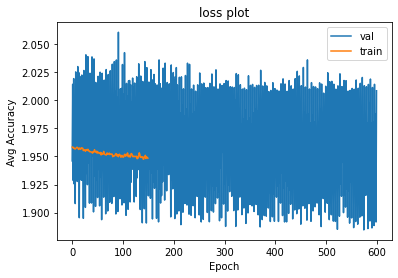

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(train_loss_history))),train_loss_history)
plt.plot(list(range(len(test_loss_history))),test_loss_history)
plt.title("loss plot")
plt.xlabel("Epoch")
plt.ylabel("Avg Accuracy")
plt.legend(["val","train"])
m=min(test_loss_history)
t=min(train_loss_history)
# plt.annotate(f"Max val acc: {m:0.2f}\nMax train acc: {t:0.2f}",(40,0.4))

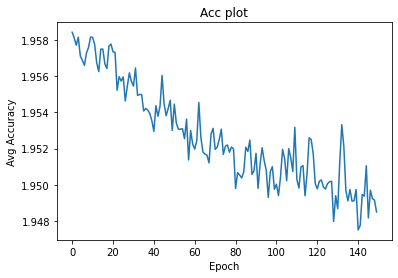

In [ ]:
# plt.plot(list(range(len(train_acc_history))),train_loss_history)
plt.plot(list(range(len(test_acc_history))),test_acc_history)
plt.title("Acc plot")
plt.xlabel("Epoch")
plt.ylabel("Avg Accuracy")
# plt.legend(["val","train"])
m=max(test_loss_history)
t=max(train_loss_history)
# plt.annotate(f"Max val acc: {m:0.2f}\nMax train acc: {t:0.2f}",(40,0.4))